In [1]:
import sys
sys.path.append('..')

import pyreadr # Para leer datos de tipo RData
import numpy as np
import cv2 as cv2
import matplotlib.pyplot as plt
from matplotlib import colors

from omegaconf import OmegaConf
from scripts.autoencoders import ConfigurableAutoencoder
from scripts.GenrationGI0 import partitioned_gi0_image
import torch
import random

In [2]:
try:
    OmegaConf.register_new_resolver("eval", eval)
except ValueError:
    pass

Cargo imágenes SAR reales para visualizarlas

In [3]:
def Ecualizauint16(img):
    hist, bins = np.histogram(img.flatten(),65536,[0,65536])
    cdf = hist.cumsum()
    cdf_m = np.ma.masked_equal(cdf, 0)  
    cdf_m = (cdf_m - cdf_m.min())*65535/(cdf_m.max()-cdf_m.min())
    cdf_equ= np.ma.filled(cdf_m,0).astype('uint16')
    return cdf_equ[img]

def plot_ecualized_image(img, title):
    img1 = np.array(img, dtype=np.float64)
    # Normalizar:
    img2 = (img1 - np.min(img1)) * 65536/(np.max(img1) - np.min(img1))
    # Pasar a entero:
    img3 = np.array(img2, dtype=np.uint16)
    # Ecualizar:
    img4 = Ecualizauint16(img3)
    
    plt.imshow(img4,cmap='gray'),plt.title(title), plt.axis('off')

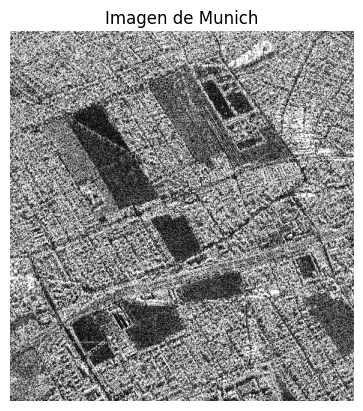

In [4]:
imageMunich = pyreadr.read_r('data/real_SAR_images/Munich.RData')
Munich = np.array(list(imageMunich.items())[0][1])
plot_ecualized_image(Munich, 'Imagen de Munich')

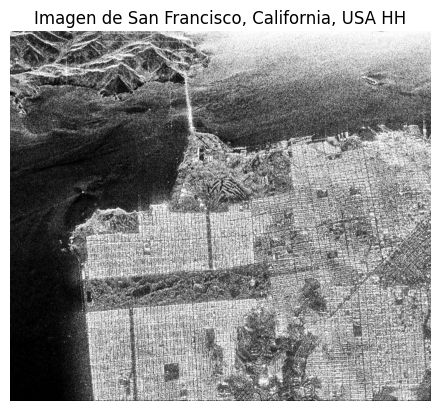

In [5]:
imageSanFran = pyreadr.read_r('data/real_SAR_images/AirSAR_SanFrancisc_Enxu.RData')
SanFran = np.array(list(imageSanFran.items())[0][1])
SanFranIm = SanFran[:,:,0] # Esta es la banda HH
plot_ecualized_image(SanFranIm, 'Imagen de San Francisco, California, USA HH')

Elegir el archivo de configuración correspondiente:

In [6]:
config_name = 'config_1-short_train' # Elegir

config_path = f'configs/{config_name}.yaml'
config = OmegaConf.load(config_path)
config

{'training': {'n': 50000, 'n_cuad_lado': [2], 'pixeles_cuad': [25], 'num_epochs': 11, 'batch_size': 64, 'learning_rate': 0.001, 'scheduler_name': 'None', 'scheduler_params': 'None'}, 'model': {'encoding_dim': 32, 'loss_function': 'mse', 'optimizer': 'adam'}, 'encoder': {'layers': [{'type': 'conv2d_transpose', 'filters': 1, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': 'sigmoid'}, {'type': 'maxpool2d', 'pool_size': 4}, {'type': 'flatten'}, {'type': 'dense', 'dim': 128, 'activation': 'relu'}, {'type': 'dense', 'dim': '${model.encoding_dim}'}]}, 'decoder': {'layers': [{'type': 'dense', 'dim': 128, 'activation': 'relu'}, {'type': 'dense', 'dim': "${eval:'(${training.n_cuad_lado[0]} * ${training.pixeles_cuad[0]})**2'}", 'activation': 'sigmoid'}, {'type': 'unflatten', 'dim1': "${eval:'${training.n_cuad_lado[0]} * ${training.pixeles_cuad[0]}'}", 'dim2': "${eval:'${training.n_cuad_lado[0]} * ${training.pixeles_cuad[0]}'}"}]}, 'testing': {'n': 1000, 'batch_size': 32}}

Cargo el autoencoder ya entrenado

In [7]:
# 1. Crear una instancia del modelo (debe tener la misma arquitectura)
autoencoder_cargado = ConfigurableAutoencoder(config=config)
# 2. Carga los parámetros
autoencoder_cargado.load_state_dict(torch.load(f'data/trained_models/{config_name}.pth'))
# 3. Modo evaluación (cuando lo use para inferencia)
autoencoder_cargado.eval()

ConfigurableAutoencoder(
  (encoder): Sequential(
    (0): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Sigmoid()
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=144, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2500, bias=True)
    (3): Sigmoid()
    (4): Unflatten(dim=1, unflattened_size=(1, 50, 50))
  )
)

In [8]:
ciudades = {
    'Munich': Munich,
    'San Francisco': SanFranIm
}

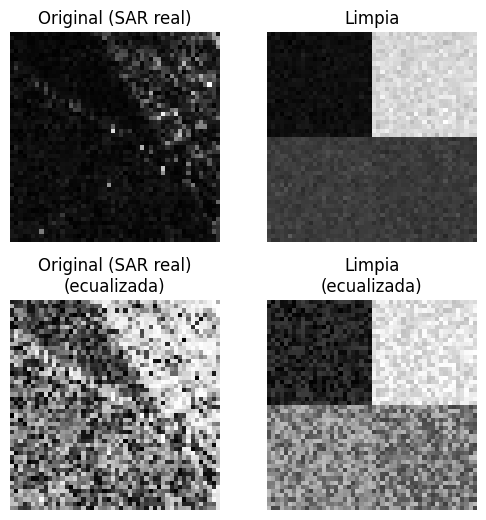

In [9]:
# Veo un pedazo (de 50x50) de una imagen real pasado por el autoencoder

ciudad = 'Munich' # Elegir ciudad según el diccionario
ecualizar_hist = True # Si se quiere o no ecualizar el histograma

i_rand = random.randint(0, ciudades[ciudad].shape[0]-50)
j_rand = random.randint(0, ciudades[ciudad].shape[1]-50)

Image = ciudades[ciudad][i_rand:i_rand+50, j_rand:j_rand+50].astype(np.float64)
Image = Image / np.max(Image)

Im_tensor = torch.from_numpy(Image).double()
Im_tensor = Im_tensor.unsqueeze(0)
Im_tensor = Im_tensor.unsqueeze(1)
autoencoder_cargado = autoencoder_cargado.double()
Processed_image = autoencoder_cargado(Im_tensor).detach().numpy()[0, 0, :, :]

Image_eq = ((Image - Image.min()) * 255) / (Image.max() - Image.min())
Image_eq = cv2.equalizeHist(Image_eq.astype(np.uint8))

Processed_image_eq = ((Processed_image - Processed_image.min()) * 255) / (Processed_image.max() - Processed_image.min())
Processed_image_eq = cv2.equalizeHist(Processed_image_eq.astype(np.uint8))
    
titulo_agregado = '\n(ecualizada)'

plt.figure(figsize=(5.3, 5.3))

plt.subplot(2, 2, 1)
plt.imshow(Image, cmap='gray')
plt.title("Original (SAR real)")
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(Processed_image, cmap='gray')
plt.title("Limpia")
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(Image_eq, cmap='gray')
plt.title("Original (SAR real)"+titulo_agregado)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(Processed_image_eq, cmap='gray')
plt.title("Limpia"+titulo_agregado)
plt.axis('off')

plt.tight_layout()
plt.show()

---
Solo para probar veo como se ve el autoencoder pasado por una imagen del conjunto de test

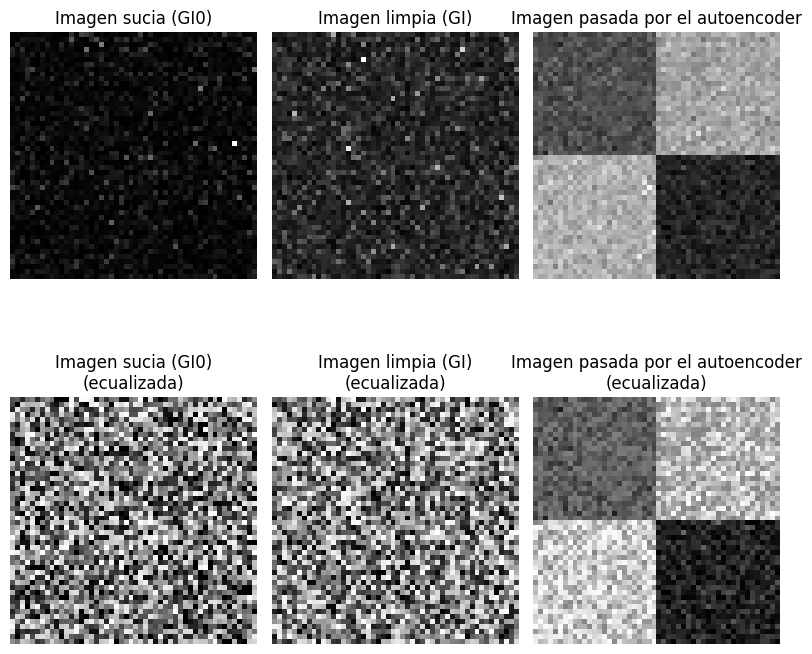

In [10]:
a = partitioned_gi0_image(
    p_alphas=[-8],
    p_gammas=[1.0],
    p_looks=[1],
    n_cuad_lado=1,
    pixeles_cuad=50
)

Image = a[2].astype(np.float64)
Image = Image / np.max(Image)
Im_tensor = torch.from_numpy(Image).double()
Im_tensor = Im_tensor.unsqueeze(0)
Im_tensor = Im_tensor.unsqueeze(1)
autoencoder_cargado = autoencoder_cargado.double()
Processed_image = autoencoder_cargado(Im_tensor).detach().numpy()[0,0,:,:]

Image_clean = a[1].astype(np.float64)
Image_clean = Image_clean / np.max(Image_clean)

Image_eq = ((Image - Image.min()) * 255) / (Image.max() - Image.min())
Image_eq = cv2.equalizeHist(Image_eq.astype(np.uint8))

Processed_image_eq = ((Processed_image - Processed_image.min()) * 255) / (Processed_image.max() - Processed_image.min())
Processed_image_eq = cv2.equalizeHist(Processed_image_eq.astype(np.uint8))

Image_clean_eq = ((Image_clean - Image_clean.min()) * 255) / (Image_clean.max() - Image_clean.min())
Image_clean_eq = cv2.equalizeHist(Image_clean_eq.astype(np.uint8))

titulo_agregado = '\n(ecualizada)'

plt.figure(figsize=(8, 8))

plt.subplot(2, 3, 1)
plt.imshow(Image, cmap='gray')
plt.title('Imagen sucia (GI0)')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(Image_clean, cmap='gray')
plt.title('Imagen limpia (GI)')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(Processed_image, cmap='gray')
plt.title("Imagen pasada por el autoencoder")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(Image_eq, cmap='gray')
plt.title("Imagen sucia (GI0)"+titulo_agregado)
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(Image_clean_eq, cmap='gray')
plt.title('Imagen limpia (GI)'+titulo_agregado)
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(Processed_image_eq, cmap='gray')
plt.title("Imagen pasada por el autoencoder"+titulo_agregado)
plt.axis('off')

plt.tight_layout()
plt.show()

El problema que se ve aca es que si el modelo fue entrenado con ciertas particiones, parece aprender los bordes de esas particiones, con lo cual no funciona bien cuando se le da imágenes con particiones diferentes. Y probablemente por esta misma razón no siempre funciona muy bien en las imágenes reales.